# 1. Import Packages and Library

In [9]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Embedding
import keras.backend as K
from keras.models import load_model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import xgboost

from sklearn.feature_extraction.text import CountVectorizer

from transformers import BertTokenizer, TFBertModel

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,recall_score

import scipy
import pandas as pd
import numpy as np
import gensim

import nltk
from nltk.data import find
import matplotlib.pyplot as plt
#import shap

import seaborn as sns
import matplotlib
import sklearn
import pickle
import random
import multiprocessing
import os
import sys
import re
import gc

from ann_visualizer.visualize import ann_viz
from keras.utils.vis_utils import plot_model

from wordcloud import wordcloud
%matplotlib inline

In [10]:
[x for x in pickle.load(open('Topic_Density_Classification/Train_Test_Data/train.pkl','rb')).columns if 'Topic' in x]

['Topic: Family/Religion',
 'Topic: Music',
 'Topic: Violence',
 'Topic: Explicit Content',
 'Topic: Dating/Love',
 'Topic: Emotion',
 'Topic: Travel/World',
 'Topic: Time',
 'Topic: Sensory Perception',
 'Topic: Energize Audience',
 'Topic: Other']

# 2. Custom Metric Functions to Evaluate Model Performance

#### Class Recall

In [11]:
def class_recall(y_true,y_pred):
    #true labels
    true = y_true.numpy()
    #predicted prob of each class for each sample
    pred = y_pred.numpy()
    #prob to class based off max predicted prob
    pred = np.array([x.argmax() for x in pred])
    #confusion matrix
    confuse = confusion_matrix(true,pred)
    confuse_sum = confuse.sum(axis=1)
    score = 0
    for num in range(len(confuse_sum)):
        if confuse_sum[num]!=0:
            score = score + confuse[num][num]/confuse_sum[num]
    
    return score/len(confuse_sum)

#### Avg Deviation

In [12]:
def density_avg_deviation(y_true,y_pred):
    #true density
    true = y_true.numpy()
    true = true/np.sum(true,axis=1).reshape((true.shape[0],1))
    #predicted density of each topic for each example
    pred = y_pred.numpy()
    pred = pred/np.sum(pred,axis=1).reshape((pred.shape[0],1))
    #absolute deviation between true and pred for each topic for each example
    deviation = abs(true-pred)
    #Avg Deviation
    avg_deviation = deviation.sum()/(deviation.shape[0]*deviation.shape[1])
    
    return avg_deviation

# 3. Visualizing Model Architectures

In [32]:
sample_model = load_model('Topic_Density_Classification/WANs/word2vec_wan_topic_density.h5',custom_objects={'density_avg_deviation':density_avg_deviation})

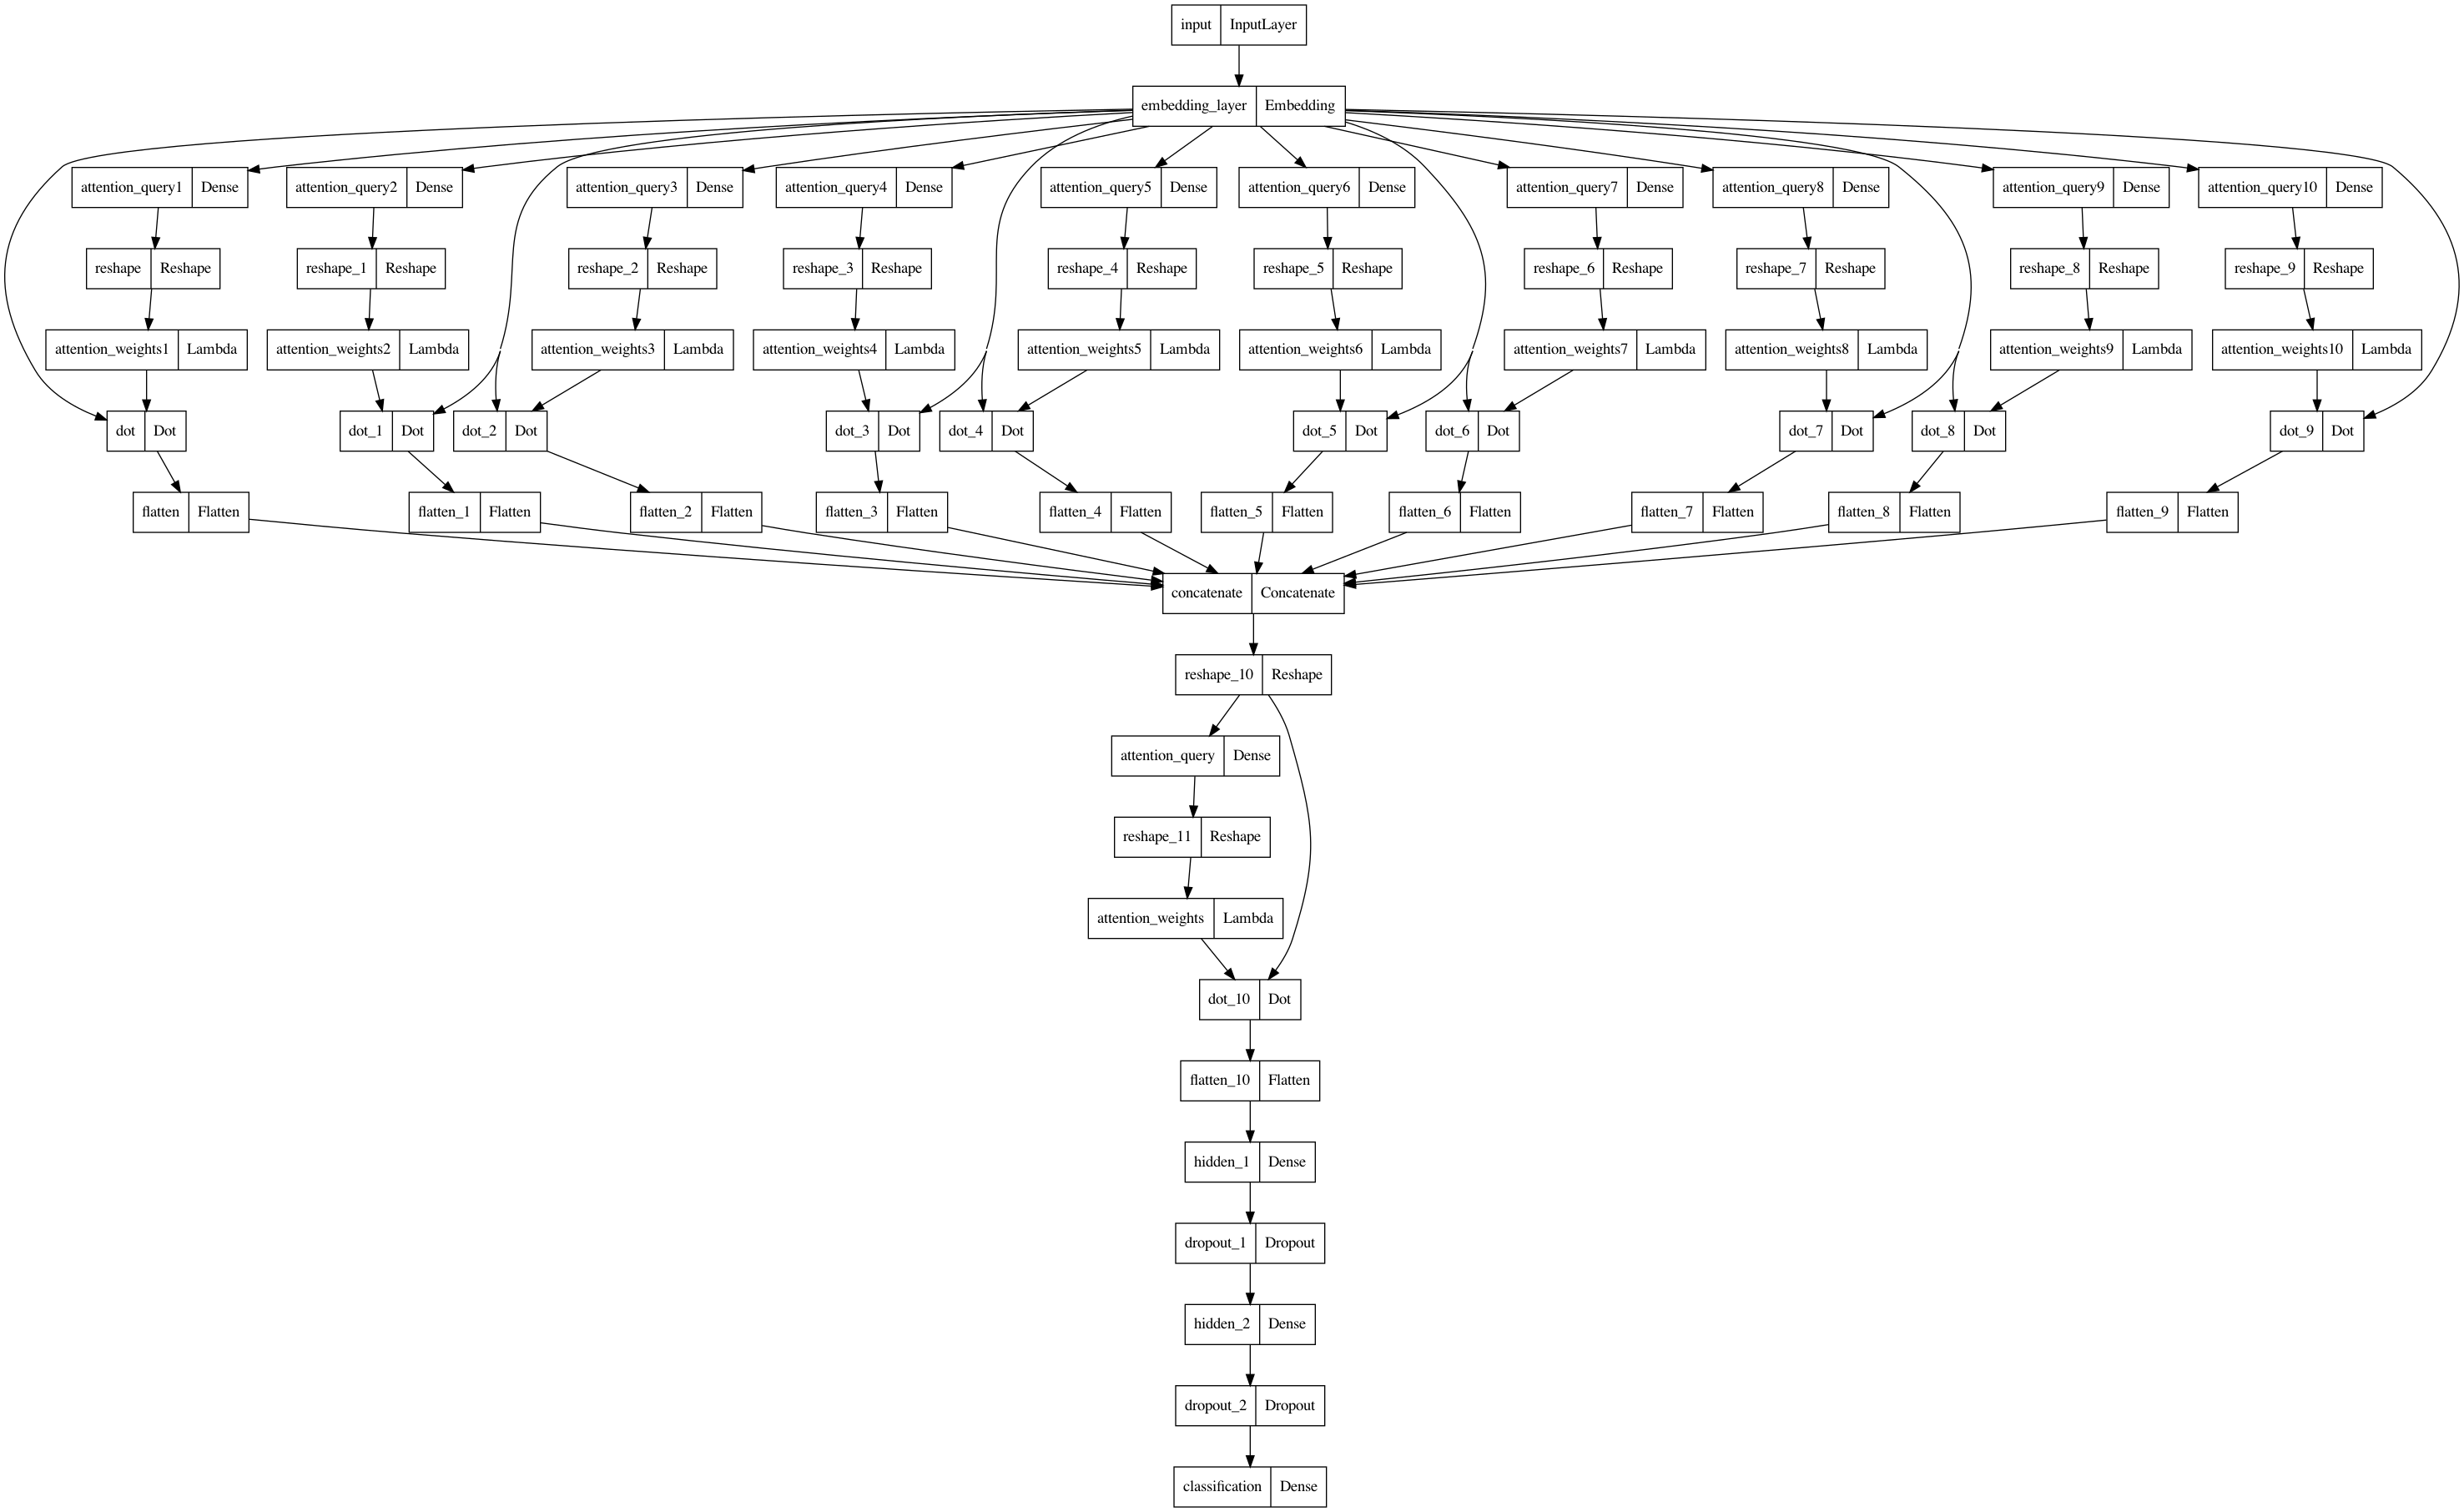

In [33]:
plot_model(sample_model)

# 4. Plot Performance of Model on Validation/Test Set

### Classification Performance Given Confusion Matrix

In [15]:
confusion_matrix = pickle.load(open('Language_Detection/ff_model_test_results.pkl','rb'))
display(confusion_matrix)
overall_acc = (np.array(confusion_matrix).diagonal().sum())/(confusion_matrix.sum().sum())
display(overall_acc)

,Spanish,Portuguese,English,Kinyarwanda,Italian,French,German,Other,Finnish,Swedish,Romanian
Spanish,285,0,1,0,0,0,0,0,0,0,0
Portuguese,0,319,0,0,0,0,0,0,0,0,0
English,2,0,302,0,0,0,0,4,0,0,0
Kinyarwanda,2,0,1,162,0,0,0,0,0,0,0
Italian,0,0,0,0,147,0,0,0,0,0,0
French,0,0,1,0,0,115,0,0,0,0,0
German,0,0,0,0,0,0,80,0,0,0,0
Other,2,1,10,1,3,0,0,42,1,0,0
Finnish,0,0,0,0,0,0,0,0,15,0,0
Swedish,0,0,0,0,0,0,0,0,0,8,0


0.980883322346737

#### Class Recall

In [16]:
class_recall_matrix = confusion_matrix/np.array(confusion_matrix.sum(axis=1).repeat(confusion_matrix.shape[1])).reshape(confusion_matrix.shape)
class_recall_matrix = round(class_recall_matrix,3)

In [17]:
display(class_recall_matrix)
recall_by_class = pd.DataFrame(np.array(class_recall_matrix).diagonal(),index = class_recall_matrix.index,columns=['Recall'])
display(recall_by_class)

,Spanish,Portuguese,English,Kinyarwanda,Italian,French,German,Other,Finnish,Swedish,Romanian
Spanish,0.997,0.000,0.003,0.000,0.00,0.000,0.0,0.000,0.000,0.0,0.0
Portuguese,0.000,1.000,0.000,0.000,0.00,0.000,0.0,0.000,0.000,0.0,0.0
English,0.006,0.000,0.981,0.000,0.00,0.000,0.0,0.013,0.000,0.0,0.0
Kinyarwanda,0.012,0.000,0.006,0.982,0.00,0.000,0.0,0.000,0.000,0.0,0.0
Italian,0.000,0.000,0.000,0.000,1.00,0.000,0.0,0.000,0.000,0.0,0.0
French,0.000,0.000,0.009,0.000,0.00,0.991,0.0,0.000,0.000,0.0,0.0
German,0.000,0.000,0.000,0.000,0.00,0.000,1.0,0.000,0.000,0.0,0.0
Other,0.033,0.017,0.167,0.017,0.05,0.000,0.0,0.700,0.017,0.0,0.0
Finnish,0.000,0.000,0.000,0.000,0.00,0.000,0.0,0.000,1.000,0.0,0.0
Swedish,0.000,0.000,0.000,0.000,0.00,0.000,0.0,0.000,0.000,1.0,0.0


,Recall
Spanish,0.997
Portuguese,1.000
English,0.981
Kinyarwanda,0.982
Italian,1.000
French,0.991
German,1.000
Other,0.700
Finnish,1.000
Swedish,1.000


#### Class Precision

In [18]:
class_precision_matrix = confusion_matrix/(np.array(confusion_matrix.sum(axis=0).repeat(confusion_matrix.shape[0])).reshape(confusion_matrix.shape).T)
class_precision_matrix = round(class_precision_matrix,3)

In [19]:
display(class_precision_matrix)
precision_by_class = pd.DataFrame(np.array(class_precision_matrix).diagonal(),index = class_precision_matrix.index,columns=['Precision'])
display(precision_by_class)

,Spanish,Portuguese,English,Kinyarwanda,Italian,French,German,Other,Finnish,Swedish,Romanian
Spanish,0.979,0.000,0.003,0.000,0.00,0.0,0.0,0.000,0.000,0.0,0.0
Portuguese,0.000,0.997,0.000,0.000,0.00,0.0,0.0,0.000,0.000,0.0,0.0
English,0.007,0.000,0.959,0.000,0.00,0.0,0.0,0.087,0.000,0.0,0.0
Kinyarwanda,0.007,0.000,0.003,0.994,0.00,0.0,0.0,0.000,0.000,0.0,0.0
Italian,0.000,0.000,0.000,0.000,0.98,0.0,0.0,0.000,0.000,0.0,0.0
French,0.000,0.000,0.003,0.000,0.00,1.0,0.0,0.000,0.000,0.0,0.0
German,0.000,0.000,0.000,0.000,0.00,0.0,1.0,0.000,0.000,0.0,0.0
Other,0.007,0.003,0.032,0.006,0.02,0.0,0.0,0.913,0.062,0.0,0.0
Finnish,0.000,0.000,0.000,0.000,0.00,0.0,0.0,0.000,0.938,0.0,0.0
Swedish,0.000,0.000,0.000,0.000,0.00,0.0,0.0,0.000,0.000,1.0,0.0


,Precision
Spanish,0.979
Portuguese,0.997
English,0.959
Kinyarwanda,0.994
Italian,0.980
French,1.000
German,1.000
Other,0.913
Finnish,0.938
Swedish,1.000


#### Class F1

In [20]:
f1_by_class = pd.DataFrame((2*recall_by_class['Recall']*precision_by_class['Precision'])/
             (recall_by_class['Recall'] + precision_by_class['Precision']),columns = ['F1'])

#### Plot Precision, Recall, F1

In [21]:
full_performance = recall_by_class.copy()
full_performance['Precision'] = precision_by_class['Precision']
full_performance['F1'] = f1_by_class['F1']
full_performance

,Recall,Precision,F1
Spanish,0.997,0.979,0.987918
Portuguese,1.000,0.997,0.998498
English,0.981,0.959,0.969875
Kinyarwanda,0.982,0.994,0.987964
Italian,1.000,0.980,0.989899
French,0.991,1.000,0.995480
German,1.000,1.000,1.000000
Other,0.700,0.913,0.792436
Finnish,1.000,0.938,0.968008
Swedish,1.000,1.000,1.000000


In [22]:
summary = full_performance.mean(axis=0)

In [23]:
recall_by_class = recall_by_class.append(pd.DataFrame([summary.iloc[0]],index = ['AVERAGE'],columns = ['Recall']))
precision_by_class = precision_by_class.append(pd.DataFrame([summary.iloc[1]],index = ['AVERAGE'],columns = ['Precision']))
f1_by_class = f1_by_class.append(pd.DataFrame([summary.iloc[2]],index = ['AVERAGE'],columns = ['F1']))


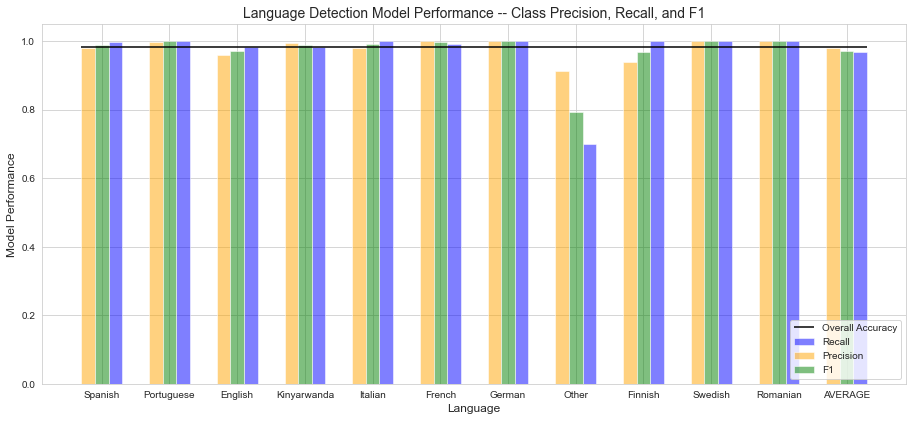

In [24]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (12,5))
axes = fig.add_axes([0,0,1,1])
axes.bar(np.arange(len(recall_by_class)) + 0.2,recall_by_class['Recall'],label = 'Recall',alpha=0.5,width=0.2,color='blue')
axes.bar(np.arange(len(precision_by_class)) - 0.2,precision_by_class['Precision'],label = 'Precision',alpha=0.5,width=0.2,color='orange')
axes.bar(np.arange(len(f1_by_class)),f1_by_class['F1'],label='F1',alpha = 0.5,width=0.2,color='green')
axes.hlines(overall_acc,xmin = -0.3, xmax = 11.3,color = 'black',label = 'Overall Accuracy')
plt.xticks(np.arange(len(f1_by_class)),f1_by_class.index)
axes.set_xlabel('Language',fontsize=12)
axes.set_ylabel('Model Performance',fontsize=12)
axes.set_title('Language Detection Model Performance -- Class Precision, Recall, and F1',fontsize=14)
axes.legend(loc=4)
plt.show()

#### Heatmaps to visualize model performance

<AxesSubplot:>

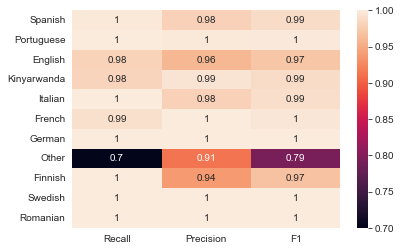

In [25]:
sns.heatmap(full_performance,annot=full_performance)

<AxesSubplot:ylabel='Model'>

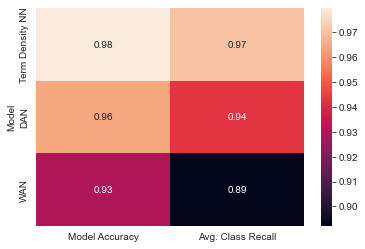

In [31]:
model_comparison = pd.DataFrame([[0.9796,0.9702],
                                 [0.9644,0.9426],
                                 [0.9301,0.8922]],
                                index = ['Term Density NN', 'DAN', 'WAN'],
                                columns = ['Model Accuracy','Avg. Class Recall'])
model_comparison.index.name = 'Model'
sns.heatmap(model_comparison,annot=model_comparison)

# Model	Accuracy	Avg. Class Recall
# Term Density NN	0.9796	0.9702
# DAN	0.9644	0.9426
# WAN	0.9301	0.8922

### Density Estimation Performance - Comparing the Deviation Between Predicted Topic Densities and Actual Topic Densities in Aggregate

#### Generate True, Predicted, and Baseline Predicted Densities (w/ the latter predicting equal density in every case)

In [74]:
test = pickle.load(open('Topic_Density_Classification/Train_Test_Data/test.pkl','rb'))[['Lyrics','Topic: Family/Religion', 'Topic: Music', 'Topic: Violence',
       'Topic: Explicit Content', 'Topic: Dating/Love', 'Topic: Emotion',
       'Topic: Travel/World', 'Topic: Time', 'Topic: Sensory Perception',
       'Topic: Energize Audience', 'Topic: Other']].iloc[1736:]
test.columns = ['Lyrics','Topic: Family/Religion', 'Topic: Music', 'Topic: Violence',
       'Topic: Explicit Content', 'Topic: Dating/Love', 'Topic: Emotion',
       'Topic: Travel/Money', 'Topic: Time', 'Topic: Sensory Perception',
       'Topic: Energize Audience', 'Topic: Other']
test['Lyrics_lower'] = test['Lyrics'].apply(lambda x: ' '.join(x.split(' Lyrics')[1:]).lower())
test_bool = test['Lyrics_lower'].apply(lambda x:True if len(str(x).split()) <= 1000 else False)
test = test[test_bool]
true_density = test.iloc[:,1:-1]
true_density.index = np.arange(len(true_density))

In [75]:
true_density

,Topic: Family/Religion,Topic: Music,Topic: Violence,Topic: Explicit Content,Topic: Dating/Love,Topic: Emotion,Topic: Travel/Money,Topic: Time,Topic: Sensory Perception,Topic: Energize Audience,Topic: Other
0,0.004577,0.050726,0.002288,0.002288,0.009153,0.055951,0.861286,0.002288,0.002288,0.002288,0.006865
1,0.002240,0.069916,0.155665,0.068726,0.096297,0.516777,0.002240,0.001120,0.001120,0.082542,0.003359
2,0.005848,0.315763,0.002924,0.002924,0.299832,0.293264,0.005848,0.058977,0.002924,0.002924,0.008772
3,0.067824,0.025922,0.001144,0.001144,0.065575,0.621224,0.124865,0.001144,0.001144,0.023908,0.066106
4,0.214458,0.381550,0.111357,0.003096,0.130031,0.006192,0.006192,0.131644,0.003096,0.003096,0.009288
...,...,...,...,...,...,...,...,...,...,...,...
1639,0.005013,0.002506,0.002506,0.618758,0.123284,0.124774,0.005013,0.002506,0.002506,0.002506,0.110627
1640,0.001096,0.000548,0.076798,0.377406,0.477667,0.001096,0.001096,0.000548,0.035199,0.026898,0.001645
1641,0.036163,0.000786,0.293218,0.521512,0.003142,0.001571,0.088487,0.000786,0.000786,0.000786,0.052764
1642,0.023073,0.000923,0.033960,0.702095,0.071306,0.001847,0.001847,0.025099,0.029422,0.056415,0.054013


In [76]:
predicted_density = pickle.load(open('Topic_Density_Classification/topic_density_WAN_test.pkl','rb'))

In [77]:
predicted_density

,Topic: Family/Religion,Topic: Music,Topic: Violence,Topic: Explicit Content,Topic: Dating/Love,Topic: Emotion,Topic: Travel/Money,Topic: Time,Topic: Sensory Perception,Topic: Energize Audience,Topic: Other
0,0.023702,0.024695,0.095660,0.002858,0.035024,0.053052,0.722609,0.004871,0.005641,0.001926,0.029962
1,0.021056,0.033095,0.099722,0.066227,0.094315,0.456755,0.175208,0.006069,0.004098,0.007353,0.036102
2,0.013706,0.353887,0.002403,0.003282,0.364474,0.220371,0.009537,0.009031,0.011023,0.002013,0.010273
3,0.056003,0.032019,0.039122,0.031525,0.108740,0.502816,0.082491,0.007511,0.025151,0.024829,0.089795
4,0.123579,0.318561,0.074210,0.015430,0.058630,0.018143,0.176994,0.045568,0.119508,0.011573,0.037802
...,...,...,...,...,...,...,...,...,...,...,...
1639,0.034158,0.043930,0.104895,0.467270,0.134995,0.067467,0.041709,0.017893,0.020838,0.024460,0.042384
1640,0.026767,0.032985,0.021198,0.422236,0.294334,0.056816,0.044498,0.022714,0.018160,0.024343,0.035948
1641,0.057893,0.009501,0.159617,0.450062,0.069392,0.021114,0.129862,0.031576,0.011352,0.021958,0.037675
1642,0.041314,0.030343,0.141104,0.464533,0.067904,0.048461,0.069218,0.018872,0.033033,0.030978,0.054238


In [78]:
baseline = pd.DataFrame((1/11)*np.ones(true_density.shape),columns = true_density.columns,index=true_density.index)

#### Get Avg Density Deviation Overall, By Topic

In [79]:
def density_avg_deviation_numpy(true,pred,calc_type = 'overall'):
    deviation = abs(true - pred)
    if calc_type == 'overall':
        return deviation.sum().sum()/(deviation.shape[0]*deviation.shape[1])
    elif calc_type == 'topic':
        return deviation.mean(axis=0)

In [80]:
pred_overall_deviation = density_avg_deviation_numpy(true_density,predicted_density)
baseline_overall_deviation = density_avg_deviation_numpy(true_density,baseline)
model_improvement = (baseline_overall_deviation - pred_overall_deviation)/baseline_overall_deviation
print('Avg Density Deviation Between True and Pred: ' + str(pred_overall_deviation))
print('Avg Density Deviation Between True and Baseline: ' + str(baseline_overall_deviation))
print('Model Improvement Over Baseline: ' + str(round(100*model_improvement,2)) + '%')

Avg Density Deviation Between True and Pred: 0.049199455139767145
Avg Density Deviation Between True and Baseline: 0.10817422613975561
Model Improvement Over Baseline: 54.52%


#### Plot Avg Density Deviation by Topic

In [81]:
pred_topic_deviation = density_avg_deviation_numpy(true_density,predicted_density,'topic')
pred_topic_deviation = pred_topic_deviation.append(pd.Series([pred_overall_deviation],index = ['AVERAGE']))
baseline_topic_deviation = density_avg_deviation_numpy(true_density,baseline,'topic')
baseline_topic_deviation = baseline_topic_deviation.append(pd.Series([baseline_overall_deviation],index = ['AVERAGE']))
improvement_over_baseline = [round(100*(x-y)/x,2) for x,y in zip(baseline_topic_deviation,pred_topic_deviation)]

In [82]:
improvement_over_baseline

[59.38,
 68.18,
 52.88,
 51.44,
 39.65,
 56.15,
 43.93,
 65.14,
 59.03,
 74.85,
 42.67,
 54.52]

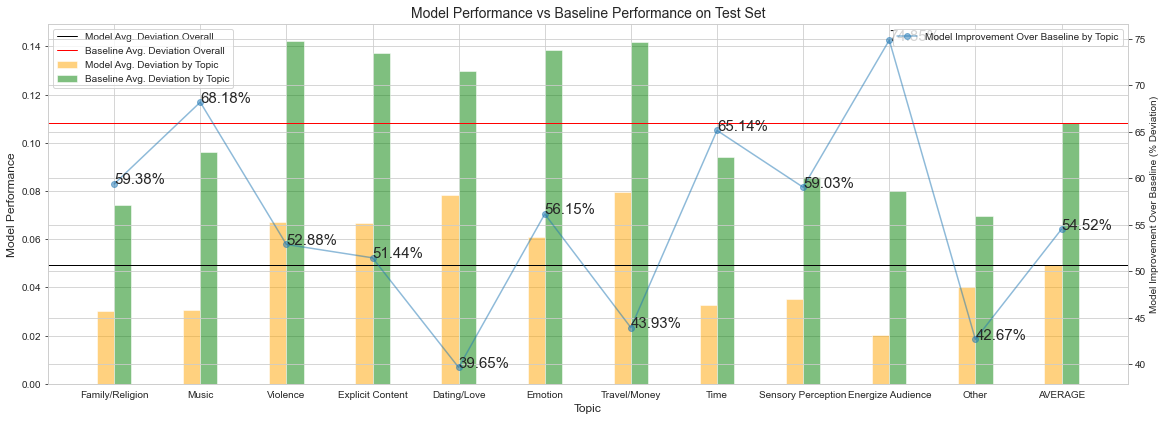

In [97]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (15,5))
axes = fig.add_axes([0,0,1,1])
axes.bar(np.arange(len(pred_topic_deviation)) - 0.1,pred_topic_deviation,label = 'Model Avg. Deviation by Topic',alpha=0.5,width=0.2,color='orange')
axes.bar(np.arange(len(baseline_topic_deviation))+0.1,baseline_topic_deviation,label = 'Baseline Avg. Deviation by Topic',alpha=0.5,width=0.2,color='green')
axes.axhline(pred_overall_deviation,color = 'black',label = 'Model Avg. Deviation Overall',lw=1)
axes.axhline(baseline_overall_deviation,color = 'red',label = 'Baseline Avg. Deviation Overall',lw=1)
axes2 = axes.twinx()
axes2.plot(np.arange(len(improvement_over_baseline)),improvement_over_baseline,
           label='Model Improvement Over Baseline by Topic',alpha = 0.5,marker = 'o')
for num in range(len(improvement_over_baseline)):
    axes2.text(num,improvement_over_baseline[num],str(improvement_over_baseline[num]) + '%',size=15)
plt.xticks(np.arange(len(pred_topic_deviation)),[x[7:] for x in pred_topic_deviation.index if x[0] == 'T'] + ['AVERAGE'])
axes.set_xlabel('Topic',fontsize=12)
axes.set_ylabel('Model Performance',fontsize=12)
axes2.set_ylabel('Model Improvement Over Baseline (% Deviation)')
axes.set_title('Model Performance vs Baseline Performance on Test Set',fontsize=14)
axes.legend(loc=2)
axes2.legend(loc=1)
plt.show()

#### Visualize Impact of Variable Embedding Sizes on OOS Model Performance for Different Model Architectures

,Embedding Size,DAN,WAN,CNN,Hybrid
0,100,0.0495,0.0480,0.0617,0.0781
1,300,0.0489,0.0508,0.0719,0.0763
2,500,0.0497,0.0492,0.0749,0.0925
3,1000,0.0511,0.0503,0.0884,0.0937


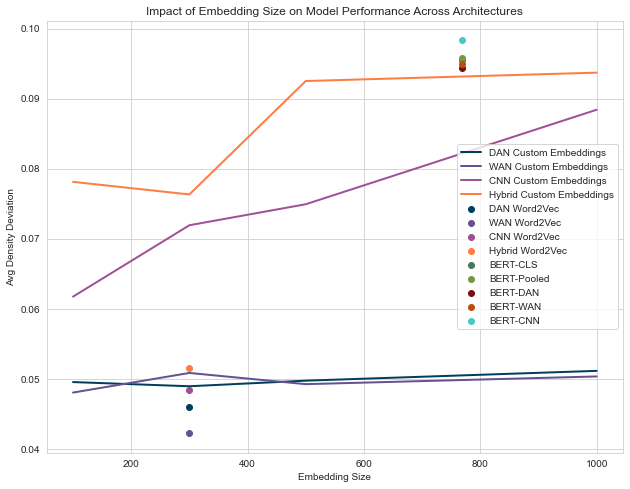

In [53]:
sample_performance = pd.DataFrame()
sample_performance['Embedding Size'] = [100,300,500,1000]
sample_performance['DAN'] = [0.0495,0.0489,0.0497,0.0511]
sample_performance['WAN'] = [0.0480,0.0508,0.0492,0.0503]
sample_performance['CNN'] = [0.0617,0.0719,0.0749,0.0884]
sample_performance['Hybrid'] = [0.0781,0.0763,0.0925,0.0937]

display(sample_performance)

fig = plt.figure(figsize = (8,6))
axes = fig.add_axes([0,0,1,1])
colors = ['#003f5c','#665191','#a05195','#ff7c43','teal']
count = 0
for arch in ['DAN','WAN','CNN','Hybrid']: #Plot Model Performance by Embedding Size for Each Architecture
    axes.plot(sample_performance['Embedding Size'],sample_performance[arch],label = arch + ' Custom Embeddings',
             color = colors[count],lw=2)
    count = count + 1

axes.scatter(300,0.0460,color = colors[0],label = 'DAN Word2Vec')
axes.scatter(300,0.0422,color = colors[1],label = 'WAN Word2Vec')
axes.scatter(300,0.0483,color = colors[2],label = 'CNN Word2Vec')
axes.scatter(300,0.0515,color = colors[3],label = 'Hybrid Word2Vec')
axes.scatter(768,0.0955,label = "BERT-CLS", color = "#46795c")
axes.scatter(768, 0.0958, label = "BERT-Pooled", color = '#78983d')
axes.scatter(768,0.0944, label = "BERT-DAN", color = '#790f0f')
axes.scatter(768,0.0950,label = 'BERT-WAN', color = '#b94d13')
axes.scatter(768,0.0983, label = "BERT-CNN", color = '#4bc8c4')
axes.set_xlabel('Embedding Size')
axes.set_ylabel('Avg Density Deviation')
axes.set_title('Impact of Embedding Size on Model Performance Across Architectures')
axes.legend()


# 5. Visualize Word Clouds

In [24]:
sample_dataset = pd.read_csv('Language_Detection/Train_Test_Data/train.csv')

def clean_text(text):
    text = text.lower()
    text = text.replace('\n',' ')
    text = text.replace('  ', ' ')
    return text
sample_dataset['Lyric'] = sample_dataset['Lyric'].apply(lambda x:clean_text(x))


sample_dataset_eng = sample_dataset[sample_dataset['language label'] == 'English'].copy()
sample_dataset_spa = sample_dataset[sample_dataset['language label'] == 'Spanish'].copy()
sample_dataset_fre = sample_dataset[sample_dataset['language label'] == 'French'].copy()

In [25]:
wc_eng = wordcloud.WordCloud(
    collocations = False, background_color='white', max_words=500, 
    width = 500, height = 500,).generate(' '.join(list(sample_dataset_eng['Lyric'])))

wc_spa = wordcloud.WordCloud(
    collocations = False, background_color='white', max_words=500, 
    width = 500, height = 500,).generate(' '.join(list(sample_dataset_spa['Lyric'])))

wc_fre = wordcloud.WordCloud(
    collocations = False, background_color='white', max_words=500, 
    width = 500, height = 500,).generate(' '.join(list(sample_dataset_fre['Lyric'])))

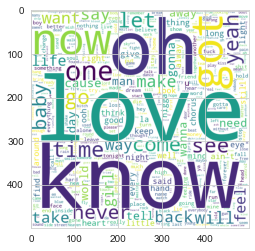

In [26]:
display(plt.imshow(wc_eng))

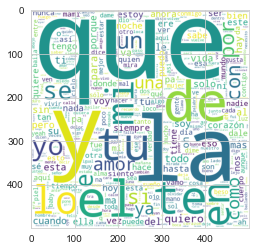

In [27]:
display(plt.imshow(wc_spa))

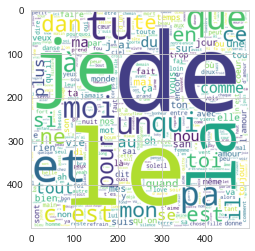

In [28]:
display(plt.imshow(wc_fre))

# 6. Analyze Word Embeddings

In [242]:
word_embeddings = pickle.load(open('Topic_Density_Classification/WANs/word2vec_embeddings.pkl','rb')).astype('float32')

In [243]:
for num in range(len(word_embeddings)):
    word_embeddings.iloc[num] = (1/np.linalg.norm(word_embeddings.iloc[num]))*word_embeddings.iloc[num]

In [244]:
def cosine_sim(word1_embed,word2_embed,normalized=False):
    word1_vec = np.array(word1_embed)
    word2_vec = np.array(word2_embed)
    dot = np.dot(word1_vec,word2_vec)
    if normalized == False:
        mag_word1 = np.linalg.norm(word1_vec)
        mag_word2 = np.linalg.norm(word2_vec)
    else:
        mag_word1 = 1
        mag_word2 = 1
    
    return dot/(mag_word1*mag_word2)

In [245]:
def cosine_sim_mat(df1,df2,normalized = False): #find cosine similarity between every point in mat1 with every point in mat 2
    # consider two points x and z: cosine sim = x*z/||x||*||z||
    
    #Store as matrics
    mat1 = np.matrix(df1).reshape(df1.shape)
    mat2 = np.matrix(df2).reshape(df2.shape)
    
    #Get matrix shape
    n,p = mat1.shape
    m,p = mat2.shape
    
    #Want to return matrix in n x m where every entry i, j = distance from ith point in matrix 1 and jth point from matrix 2
    
    #Gram Schmidt Matrix: entry i,j = dot product between ith point in matrix 1 with jth point in matrix 2
    G = np.dot(mat1, mat2.T)
    
    if normalized == False:
        # X Magnitude Matrix: nxm matrix where ith row = magnitude of ith vector in matrix 1
        x_mag = np.sqrt(np.array([np.dot(mat1[num],mat1[num].T) for num in range(len(mat1))]).flatten()).repeat(m).reshape((n,m))

        # Z Magnitude Matrix: nxm matrix where ith column = magnitude of ith vector in matrix 2
        z_mag = np.sqrt(np.array([np.dot(mat2[num],mat2[num].T) for num in range(len(mat2))]).flatten()).repeat(n).reshape((m,n)).T

        sim_mat = np.divide(G,np.multiply(x_mag,z_mag))
    else:
        sim_mat = G
        
    try:
        sim_mat = pd.DataFrame(sim_mat,index = df1.index,columns = df2.index)
    except:
        sim_mat = pd.DataFrame(sim_mat,index = df1.index)
    
    return sim_mat

In [246]:
def find_most_similar(df1,word_embed,normalized=False,k=1):
    
    sim_mat = cosine_sim_mat(df1,np.array(word_embed).reshape((1,len(word_embed))),normalized=normalized)
    try:
        sim_mat.drop(word_embed.name,inplace=True)
    except:
        sim_mat = sim_mat
        
    sim_mat.sort_values(sim_mat.columns[0],inplace=True,ascending=False)
    best_match = sim_mat.iloc[:k]
    
    return best_match

In [247]:
def do_analogy(df1,word1,word2,word3,normalized = False):
    '''
    word1 is to word2 as word3 is to <word4>
    '''
    similarity = cosine_sim(word1,word2,normalized=normalized)
    sim_mat = cosine_sim_mat(df1,word3,normalized=normalized)
    sim_mat[0] = abs(sim_mat[0] - similarity)
    best_match = sim_mat[sim_mat[0] == sim_mat[0].min()].copy()
    
    return similarity, best_match, df1.loc[best_match.index[0]]

In [281]:
find_most_similar(word_embeddings,word_embeddings.loc['eating'],normalized=True,k=5)

,0
chicken,0.649642
examining,0.618055
tofu,0.582828
blackboard,0.569547
allergy,0.559420


In [289]:
do_analogy(word_embeddings,word_embeddings.loc['socks'], word_embeddings.loc['feet'],word_embeddings.loc['gloves'])

(0.010179165,
                   0
 defenders  0.000005,
 0      0.121669
 1      0.068366
 2      0.037954
 3      0.037286
 4     -0.003816
          ...   
 295    0.013301
 296   -0.015597
 297   -0.056715
 298   -0.045713
 299    0.084470
 Name: defenders, Length: 300, dtype: float32)